# Tutorial 07 - Convolutional Neural Networks

## Cats vs Dogs
Dataset can be downloaded from http://files.fast.ai/data/dogscats.zip  
Classification to 2 classes  
Basic setup as before:

In [1]:
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
root_dir = '../dogscats/train'

target_size = (32, 32)
transforms = Compose([Resize(target_size), # Resizes image
                    ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_dataset = ImageFolder(root_dir, transform=transforms)

In [3]:
len(train_dataset)

23000

In [5]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)

In [6]:
# Same for validation dataset
val_root_dir = '../dogscats/valid'
val_dataset = ImageFolder(val_root_dir, transform=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(len(val_dataset))

# Baseline - MLP model
### We will compare MLP and ConvNets in terms of accuracy, number of parameters, etc.

from utils_train import fit

In [39]:
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [48]:
model_mlp = MLPModel(32*32*3, 128)
model_mlp = model_mlp.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [49]:
curves_mlp = fit(train_dataloader, val_dataloader, model_mlp, optimizer, loss_fn, n_epochs)

Epoch 1/25: train_loss: 0.6514, train_accuracy: 61.7783, val_loss: 0.6334, val_accuracy: 63.7500
Epoch 2/25: train_loss: 0.6210, train_accuracy: 64.9348, val_loss: 0.6183, val_accuracy: 65.2000
Epoch 3/25: train_loss: 0.5980, train_accuracy: 67.5391, val_loss: 0.6212, val_accuracy: 66.2000
Epoch 4/25: train_loss: 0.5795, train_accuracy: 69.1826, val_loss: 0.6072, val_accuracy: 66.9500
Epoch 5/25: train_loss: 0.5575, train_accuracy: 71.0826, val_loss: 0.6220, val_accuracy: 65.6500
Epoch 6/25: train_loss: 0.5325, train_accuracy: 72.9435, val_loss: 0.6242, val_accuracy: 65.9000
Epoch 7/25: train_loss: 0.5114, train_accuracy: 73.9391, val_loss: 0.6226, val_accuracy: 66.4000
Epoch 8/25: train_loss: 0.4857, train_accuracy: 75.4304, val_loss: 0.6386, val_accuracy: 67.9500
Epoch 9/25: train_loss: 0.4576, train_accuracy: 77.5609, val_loss: 0.6625, val_accuracy: 66.4000
Epoch 10/25: train_loss: 0.4298, train_accuracy: 79.3130, val_loss: 0.6900, val_accuracy: 67.3000
Epoch 11/25: train_loss: 0.40

### With some regularization the best accuracy we got before for this MLP model was ~68%

## Convolutional Neural Network
### Two convolutions with Max Pooling, followed by linear layer on flattened feature maps

In [25]:
import torch.nn as nn
    
class ConvModel(nn.Module):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3x32x32
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),
            # output: 16x28x28 (because kernel_size=5 and no padding)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 16x14x14
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            # output: 32x10x10
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 32x5x5
        )
        self.linear_layer = nn.Linear(32*5*5, 2) # map output of conv layers to number of outputs (2 classes in this case)
    
    def forward(self, input):
        output = self.conv_layers(input) # NO FLATTENING HERE, expected input is of dimension batch_size x n_channels x im_height x im_width
        output = output.view(output.size(0), 32*5*5) # Flatten to a vector before passing to a linear layer
        output = self.linear_layer(output)
        return output

In [52]:
model_conv = ConvModel()
model_conv = model_conv.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [53]:
curves_conv1 = fit(train_dataloader, val_dataloader, model_conv, optimizer, loss_fn, n_epochs)

Epoch 1/25: train_loss: 0.6098, train_accuracy: 66.3913, val_loss: 0.5701, val_accuracy: 70.7500
Epoch 2/25: train_loss: 0.5302, train_accuracy: 73.5000, val_loss: 0.5107, val_accuracy: 75.4500
Epoch 3/25: train_loss: 0.4844, train_accuracy: 76.6913, val_loss: 0.4954, val_accuracy: 76.7000
Epoch 4/25: train_loss: 0.4543, train_accuracy: 78.7696, val_loss: 0.4654, val_accuracy: 78.8500
Epoch 5/25: train_loss: 0.4292, train_accuracy: 80.2130, val_loss: 0.4549, val_accuracy: 78.9000
Epoch 6/25: train_loss: 0.4148, train_accuracy: 81.0000, val_loss: 0.4308, val_accuracy: 79.8000
Epoch 7/25: train_loss: 0.3994, train_accuracy: 81.7783, val_loss: 0.4401, val_accuracy: 79.0500
Epoch 8/25: train_loss: 0.3823, train_accuracy: 82.7043, val_loss: 0.4451, val_accuracy: 79.2500
Epoch 9/25: train_loss: 0.3682, train_accuracy: 83.2870, val_loss: 0.4372, val_accuracy: 79.4000
Epoch 10/25: train_loss: 0.3547, train_accuracy: 84.2348, val_loss: 0.4333, val_accuracy: 80.2000
Epoch 11/25: train_loss: 0.34

In [65]:
import torch.nn as nn
    
class ConvModel2(nn.Module):
    
    def __init__(self):
        super(ConvModel2, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3x32x32
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),
            # output: 16x28x28 (because kernel_size=5 and no padding)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 16x14x14
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            # output: 32x10x10
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 32x5x5
            nn.AvgPool2d(kernel_size=5, stride=5) # alternatively: AdaptiveAvgPool(1)
        )
        self.linear_layer = nn.Linear(32, 2)
    
    def forward(self, input):
        output = self.conv_layers(input)
        output = output.view(output.size(0), 32)
        output = self.linear_layer(output)
        return output

In [66]:
model_conv2 = ConvModel2()
model_conv2 = model_conv2.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_conv2.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [56]:
curves_conv2 = fit(train_dataloader, val_dataloader, model_conv2, optimizer, loss_fn, n_epochs)

Epoch 1/25: train_loss: 0.6516, train_accuracy: 61.4565, val_loss: 0.6446, val_accuracy: 62.6500
Epoch 2/25: train_loss: 0.6161, train_accuracy: 66.3870, val_loss: 0.6021, val_accuracy: 68.3500
Epoch 3/25: train_loss: 0.5827, train_accuracy: 69.5652, val_loss: 0.5706, val_accuracy: 71.4000
Epoch 4/25: train_loss: 0.5584, train_accuracy: 71.8565, val_loss: 0.5539, val_accuracy: 72.7500
Epoch 5/25: train_loss: 0.5346, train_accuracy: 73.8652, val_loss: 0.5325, val_accuracy: 74.3500
Epoch 6/25: train_loss: 0.5171, train_accuracy: 75.0696, val_loss: 0.5119, val_accuracy: 75.8500
Epoch 7/25: train_loss: 0.5081, train_accuracy: 75.4391, val_loss: 0.5127, val_accuracy: 75.5500
Epoch 8/25: train_loss: 0.4992, train_accuracy: 76.1261, val_loss: 0.5313, val_accuracy: 73.6500
Epoch 9/25: train_loss: 0.4889, train_accuracy: 76.6348, val_loss: 0.4859, val_accuracy: 76.7500
Epoch 10/25: train_loss: 0.4828, train_accuracy: 77.0652, val_loss: 0.4793, val_accuracy: 77.0000
Epoch 11/25: train_loss: 0.47

# Compare number of parameters

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [144]:
print('MLP: {} parameters'.format(count_parameters(model_mlp)))
print('ConvNet1: {} parameters'.format(count_parameters(model_conv)))
print('ConvNet2: {} parameters'.format(count_parameters(model_conv2)))

MLP: 426626 parameters
ConvNet1: 15650 parameters
ConvNet2: 14114 parameters


__Model MLP__:
- 1st layer: (32 * 32 * 3)*128 + 128 (biases) __// input size dependant, 92% of parameters!__
- 2nd layer: 128 * 128 + 128
- 3rd layer: 128 * 128 + 128
- 4th layer: 128 * 2 + 2

__Model ConvNet1__:
- 1st layer (conv): 16 * 3 * 5 * 5 + 16 (biases)
- 2nd layer (conv): 32 * 16 * 5 * 5 + 32
- 3rd layer (linear): (32 * 5 * 5) * 2 + 2 __// input size dependant__ <- can grow very big for bigger input size and large number of filters

__Model ConvNet2__:
- 1st layer (conv): 16 * 3 * 5 * 5 + 16 (biases)
- 2nd layer (conv): 32 * 16 * 5 * 5 + 32
- 3rd layer (linear): 32 * 2 + 2  
^ Independent of input size (average pool must be set accordingly)

# First conv layer filter visualization
## What does the network look for in the raw image?

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

### Example: AlexNet, trained on ImageNet dataset (>1 million images, 1000 classes) https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

In [124]:
import torchvision
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/adam/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:03, 80403245.62it/s]


In [168]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [152]:
filters = alexnet.features[0].weight.detach().cpu().numpy()

In [153]:
filters.shape

(64, 3, 11, 11)

In [154]:
filters = filters.transpose(0, 2, 3, 1)

In [155]:
filters_ = filters.copy()

In [156]:
for i in range(len(filters_)):
    filters_[i] -= np.min(filters_[i])
    filters_[i] /= np.max(filters_[i])

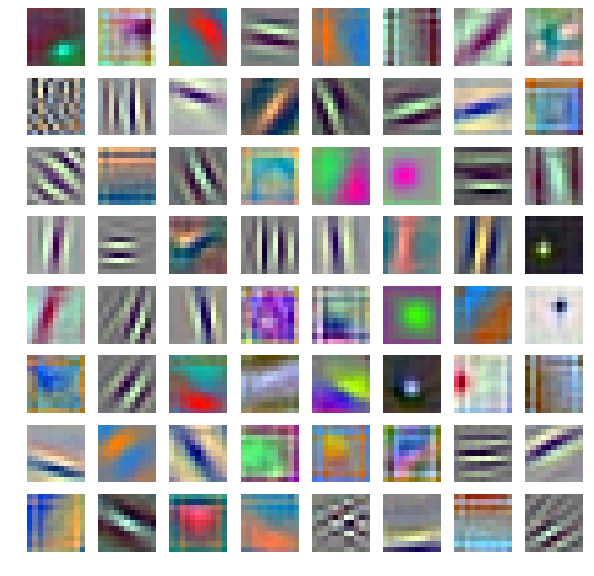

In [167]:

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(64):
    axes[i // 8][i % 8].imshow(filters_[i], cmap='gray')
    axes[i // 8][i % 8].axis('off')